In [190]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import glob
import os
import seaborn as sns
import re

## Analysis of ML results

In [284]:
results_path = '/home/robert/Documents/projects/ML_genetic_risk/results/pheno1/'

In [285]:
def load_pickle(file):
    return pickle.load(open(file, 'rb'))

### Overall Performance 

In [286]:
files = glob.glob(os.path.join(results_path, 'eval*'))

/home/robert/software/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


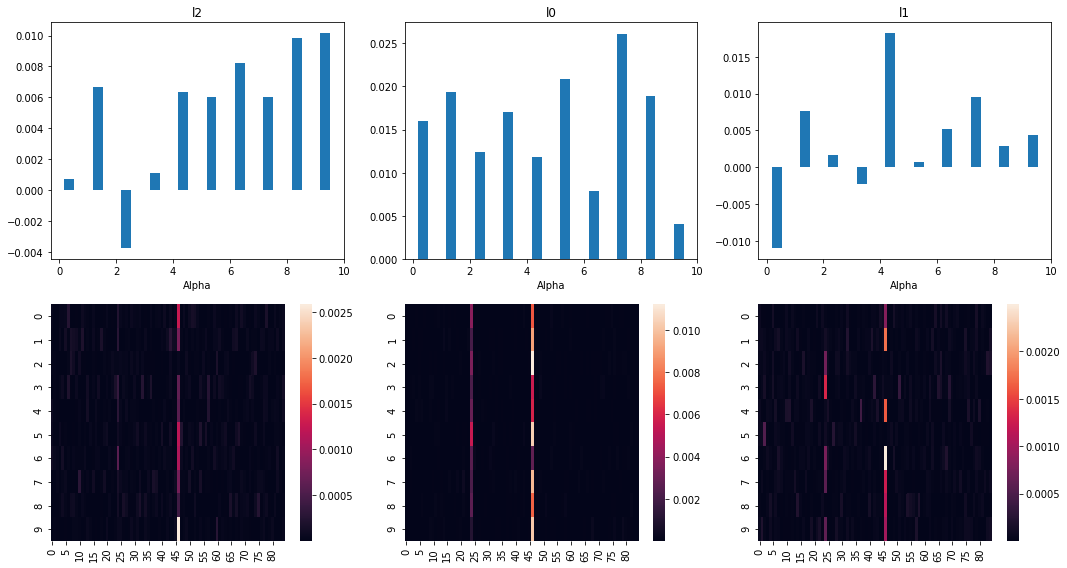

In [287]:
fig, ax = plt.subplots(2, len(files), figsize=(15, 8))
for i, f in enumerate(files):
    title = re.search('l[0-9]', f).group(0)
    dat = load_pickle(f)
    n_groups = len(dat['Overall'])
    index = np.arange(n_groups)
    bar_width = 0.35
    ax[0, i].bar(index + bar_width, dat['Overall'], bar_width)
    ax[0, i].set_title(title)
    ax[0, i].set_xlabel('Alpha')
    sns.heatmap(dat['Block'], ax=ax[1, i])

fig.tight_layout()
fig.show()
fig.savefig('/home/robert/Documents/projects/ML_genetic_risk/doc/presentation/sim_results/performance.png')

### Block SGD performance

In [288]:
file_models = glob.glob(os.path.join(results_path, 'model*'))
print(file_models)

['/home/robert/Documents/projects/ML_genetic_risk/results/pheno1/models_l2.pickle', '/home/robert/Documents/projects/ML_genetic_risk/results/pheno1/models_l0.pickle', '/home/robert/Documents/projects/ML_genetic_risk/results/pheno1/models_l1.pickle']


/home/robert/software/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


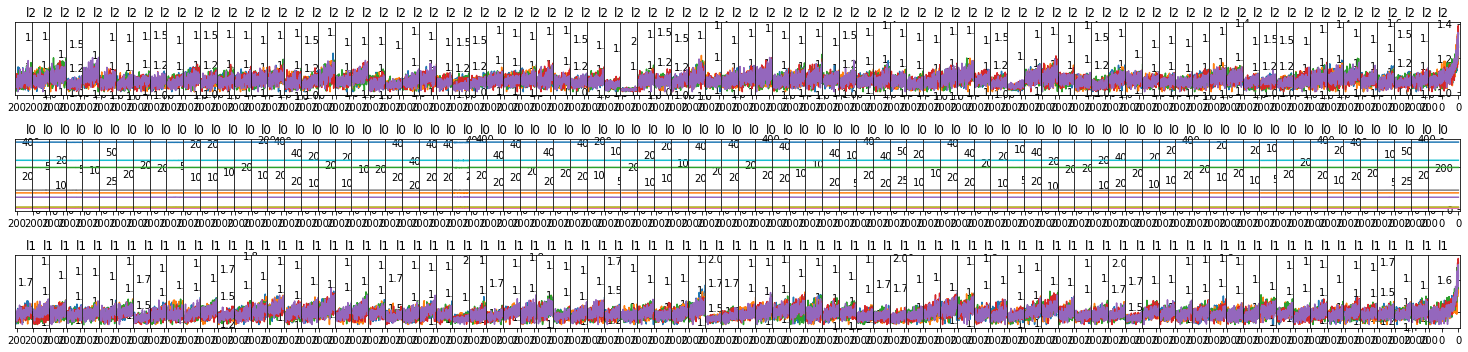

In [180]:
dat = load_pickle(file_models[0])
fig, ax = plt.subplots(len(file_models), len(dat), figsize=(20, 5))
for y, f in enumerate(file_models):
    dat = load_pickle(f)
    name = re.search('l[0-9]', f).group(0)
    for i, block in enumerate(dat):
        for u, alpha in enumerate(block['model']):
            ax[y, i].plot(range(alpha['param']['epoch']), alpha['param']['loss'], label=str(alpha['param']['lambda']))
            ax[y, i].set_title(name)
fig.tight_layout()
fig.show()

/home/robert/software/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


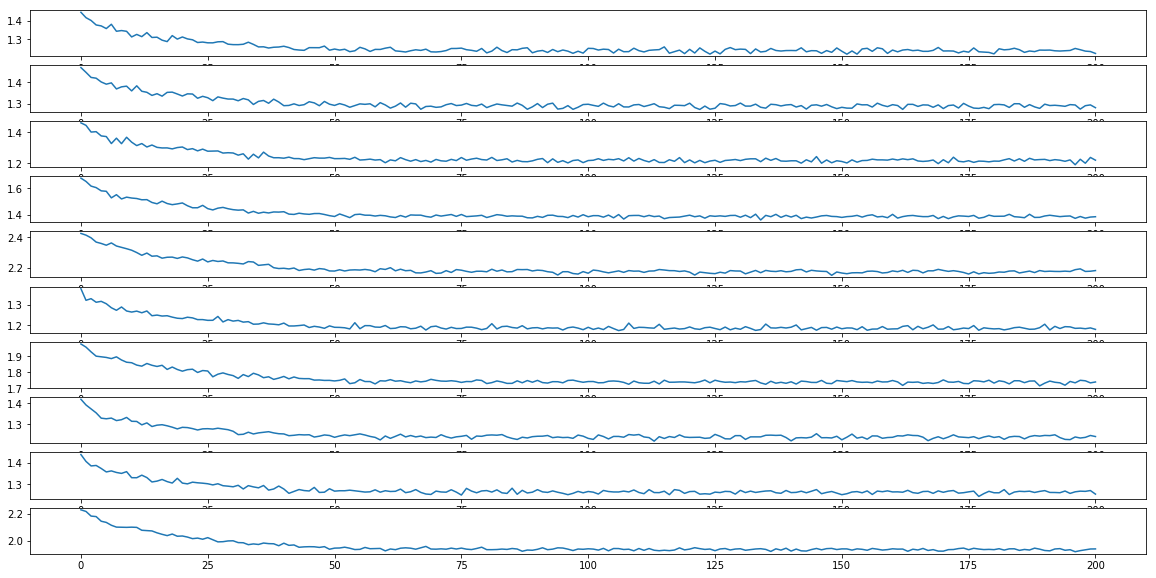

In [294]:
dat = load_pickle(file_models[2])
fig, ax = plt.subplots(10, 1, figsize=(20, 10))
ss = np.random.choice(range(len(dat)), 1)
for k, i in np.ndenumerate(ss):
    block = dat[i]
    for u, alpha in enumerate(block['model']):
        ax[u].plot(range(alpha['param']['epoch']), alpha['param']['loss'], label=str(alpha['param']['lambda']))
fig.show()

### Parameter Space

In [295]:
def paramter_details(dat, param_id = 0):
    n_blocks = len(dat)

    block_info = []
    for i in range(n_blocks):
        block = dat[i]
        collection = {'parameter': [],
                      'zero_parameters': [],
                      'abs_sum_parameters': [],
                      'alphas': []}
        for alphas in block['model']:
            param = alphas['coef'][param_id].flatten()
            collection['parameter'].append(len(param))
            collection['zero_parameters'].append(np.sum(~(param > 0)))
            collection['abs_sum_parameters'].append(np.sum(np.abs(param)))
            collection['alphas'].append(alphas['param']['lambda'])
        block_info.append(collection)
    return block_info

In [296]:
def proportion_matrix(block_info):
    n_blocks = len(block_info)
    n_alphas = len(block_info[0]['alphas'])
    prop_matrix = np.zeros((n_alphas, n_blocks))
    for index, bb in enumerate(block_info):
        ddd = pd.DataFrame.from_dict(bb, orient='index').T
        prop_matrix[:, index] = (ddd.zero_parameters / ddd.parameter).values
    return prop_matrix

/home/robert/software/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


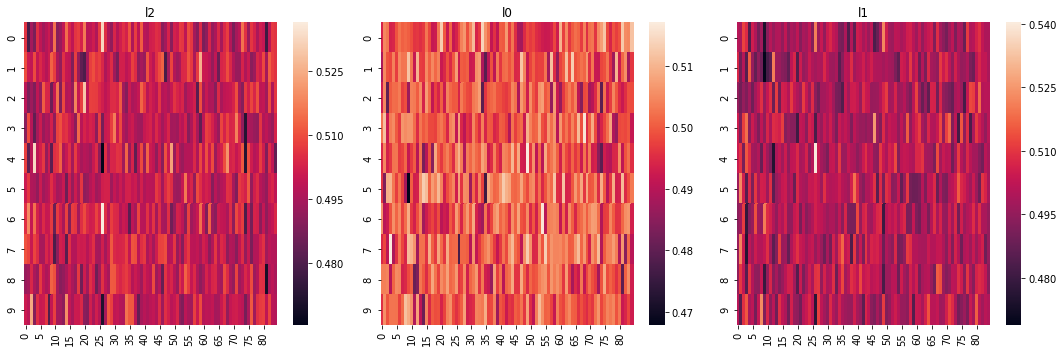

In [298]:
fig, ax = plt.subplots(1, len(file_models), figsize=(15, 5))
for i, f in enumerate(file_models):
    title = re.search('l[0-9]', f).group(0)
    param_id = 0 if title!='l0' else 1
    dat = load_pickle(f)
    block_info = paramter_details(dat, param_id)
    prop_matrix = proportion_matrix(block_info)
    sns.heatmap(prop_matrix, ax=ax[i])
    ax[i].set_title(title)

fig.tight_layout()
fig.show()
fig.savefig('/home/robert/Documents/projects/ML_genetic_risk/doc/presentation/sim_results/null_proportion.png')

In [319]:
dat = load_pickle(file_models[2])
print('length of dat', len(dat), 'is the number of blocks')
print('dict key for each block is:', dat[0].keys())
print('length for each key is:', [len(i) for k, i in dat[0].items()])
print('the model is displayed as:', type(dat[0]['model']), 'with ', len(dat[0]['model']), 'items')
print('the predictrion is displayed as:', type(dat[0]['pred']), 'with ', dat[0]['pred'].shape)
print('each item in the model list is a', type(dat[0]['model'][0]), 'with ', dat[0]['model'][0].keys())

length of dat 85 is the number of blocks
dict key for each block is: dict_keys(['pred', 'model', 'accu', 'pheno'])
length for each key is: [28570, 10, 10, 28570]
the model is displayed as: <class 'list'> with  10 items
the predictrion is displayed as: <class 'numpy.ndarray'> with  (28570, 10)
each item in the model list is a <class 'dict'> with  dict_keys(['accu', 'param', 'pred', 'coef'])


In [313]:
dat_overall = load_pickle(files[2])

In [318]:
best_lamb = np.argmax(dat_overall['Overall'])
print('keys in the dict', dat_overall.keys())

keys in the dict dict_keys(['Overall', 'Block'])


In [321]:
def get_overall_prediction(dat, best_lambda):
    pred = sum([k['pred'] for k in dat])
    return pred[:, best_lambda]

In [323]:
y_hat = get_overall_prediction(dat, best_lamb)
y = dat[0]['pheno']

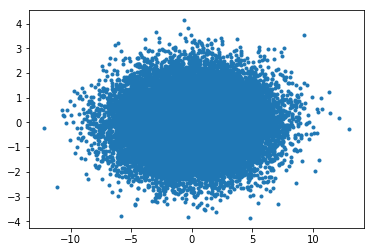

In [325]:
plt.plot(y_hat, y, '.')